# Introduction

introduce the problem of storing multidimensional array data and accessing it efficiently.

note that hdf5 is perhaps the most well-known solution, but there are newer alternatives designed from the start to integrate well with python data science pipelines.

these days, focus is also shifting to how to store and access array data on the cloud, which presents different challenges.

in this article we will compare TileDB to two python libraries for compressed, chunked array data storage and retrieval. the two libraries are bcolz and zarr.

the machine used to run these experiments is a `c5x.4xlarge` instance on AWS EC2.

due to the performance variability of EBS, we chose this instance for its dedicated SSD storage option. All experiments on local disk were run on the dedicated SSD.

In [1]:
%matplotlib inline

import bcolz
import matplotlib.pyplot as plt
import numcodecs
import numpy as np
import os
import shutil
import subprocess
import tiledb
import time
import zarr

# One-dimensional arrays

we'll start with one-dimensional data, which will help us introduce the three libraries and get some initial understanding of their relative performance.

the benchmark data will be an array of 8-byte floating point values stored initially in a numpy array. we'll use the three libraries to separately serialize the numpy array to disk.

Note that because the data is random, we don't expect to see much gain with compression by either system.

## Array creation

In [2]:
num_array_values = 100000000
array_data = np.random.rand(num_array_values)
print('Array data is {:.2f} MB uncompressed.'.format(array_data.nbytes / (1024 * 1024.0)))

Array data is 762.94 MB uncompressed.


Next we choose names for the arrays that will be stored on disk and choose a compressor setting.

In [3]:
tiledb_array_name = 'tiledb_array'
bcolz_array_name = 'bcolz_array'
zarr_array_name =  'zarr_array'

array_root_dir = '/ssd'
tiledb_array_path = os.path.join(array_root_dir, tiledb_array_name)
bcolz_array_path = os.path.join(array_root_dir, bcolz_array_name)
zarr_array_path = os.path.join(array_root_dir, zarr_array_name)

tiledb_compressor = ('blosc-lz4', 5)
zarr_compressor = numcodecs.Blosc(cname='lz4', clevel=5)
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5

We'll define some helper functions to create persistent arrays with a given tile or chunk size, and also to remove the arrays.

TileDB has the extra step of explicitly defining an `ArraySchema` which controls the domain of the array, its dimensionality, tiling strategy, and datatypes.

In [4]:
def sync_fs():
    "Flushes pending writes to the local filesystem."
    subprocess.check_call(['sudo', 'sync'])


def write_1d_tiledb_array(array_data, tile_extent):
    ctx = tiledb.Ctx()
    dom = tiledb.Domain(ctx, tiledb.Dim(ctx, domain=(0, num_array_values - 1),
                                        tile=tile_extent, dtype=np.uint32))
    schema = tiledb.ArraySchema(ctx, domain=dom, sparse=False,
                                attrs=[tiledb.Attr(ctx, name='a', dtype=np.float64, compressor=tiledb_compressor)])
    tiledb.DenseArray.create(tiledb_array_path, schema)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='w') as A:
        A[:] = array_data
    sync_fs()


def write_1d_bcolz_array(array_data, tile_extent):
    A = bcolz.carray(array_data, rootdir=bcolz_array_path, mode='w', chunklen=tile_extent)
    A.flush()
    sync_fs()


def write_1d_zarr_array(array_data, tile_extent):
    A = zarr.open(zarr_array_path, mode='w', compressor=zarr_compressor, shape=array_data.shape, chunks=(tile_extent,),
                  dtype=np.float64)
    A[:] = array_data
    sync_fs()

We'll also define a helper function to time a function call a number of times.

In [5]:
def drop_fs_cache():
    "Drops the OS filesystem cache(s)."
    # On macOS: subprocess.call(['sudo', 'purge'])
    subprocess.call(['sudo', 'sh', '-c', 'echo 3 >/proc/sys/vm/drop_caches'])
    
    
def remove_arrays():
    "Remove any persisted arrays."
    for array in [tiledb_array_path, bcolz_array_path, zarr_array_path]:
        if os.path.exists(array):
            shutil.rmtree(array)


def timeit(fnc, setup=None, repeat=3):
    "Time a function's execution."
    times = []
    for i in range(0, repeat):
        if setup is not None:
            setup()
        start = time.time()
        fnc()
        end = time.time()
        times.append(end - start)
    return times


Next we'll persist the array data separately using each library and plot the minimum time over 3 iterations. We'll create the array with the same data several times, but modifying the tile/chunk extent each time.

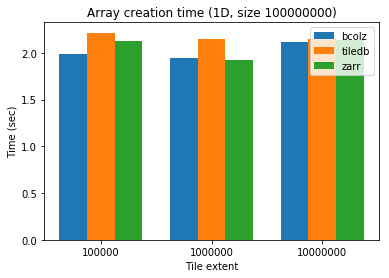

In [6]:
def plot_bars(times_per_library, title, xlabel, ylabel):
    bar_width = 0.25
    xpos1 = np.arange(len(times_per_library['tiledb']))
    xpos2 = xpos1 + bar_width
    xpos3 = xpos2 + bar_width
    xpos = [xpos1, xpos2, xpos3]
    
    plt.figure()
    for i, key in enumerate(sorted(times_per_library.keys())):
        plt.bar(xpos[i], times_per_library[key], width=bar_width, label=key)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xpos1 + bar_width, tile_extents)
    
    plt.legend()
    plt.show()


array_creation_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
tile_extents = [100000, 1000000, 10000000]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_1d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_1d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['bcolz'].append(
        min(timeit(lambda: write_1d_bcolz_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

plot_bars(array_creation_times, 'Array creation time (1D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')


interpret the above results: it's likely to be similar for all libraries

## Single-cell reads

Next we'll examine how read performance varies with the tile/chunk size when reading a single value (cell) from the arrays.

in general with all of these chunked formats, the main tuning parameter for read performance is controlling the chunk size. 

small chunk sizes are better for smaller reads (as a higher percentage of each chunk will contain values that intersect the region of the array being read), but can result in high overhead for large reads (due to many distinct i/o and decompression operations).

large chunk sizes are better for larger reads due to better streaming i/o and decompression.

so on the smallest extreme, reading a single cell, we expect to do better in all cases with the smaller chunk size.

to begin with we'll define helper functions that read a specified region ("subarray") of the array for each library.

In [7]:
def read_tiledb_1d_subarray(subarray):
    ctx = tiledb.Ctx()
    drop_fs_cache()
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1]]


def read_bcolz_1d_subarray(subarray):
    drop_fs_cache()
    with bcolz.carray(rootdir=bcolz_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1]]


def read_zarr_1d_subarray(subarray):
    drop_fs_cache()
    A = zarr.open(zarr_array_path, mode='r')
    data = A[subarray[0] : subarray[1]]

Next we'll time and plot the results over 10 iterations.

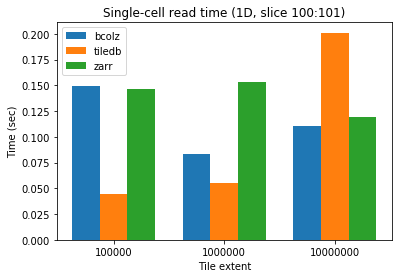

In [8]:
single_cell_read_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
subarray = (100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_1d_tiledb_array(array_data, t_ext)
    write_1d_bcolz_array(array_data, t_ext)
    write_1d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_1d_subarray(subarray), repeat=10)))
    single_cell_read_times['bcolz'].append(min(timeit(lambda: read_bcolz_1d_subarray(subarray), repeat=10)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_1d_subarray(subarray), repeat=10)))

plot_bars(single_cell_read_times, 'Single-cell read time (1D, slice {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

interpret above results here

## Multi-cell reads

next we'll repeat the above experiment but with a larger subarray slice. because each chunked format treats the chunk as the minimum I/O size, if the subarray slice is entirely within a single chunk/tile, the result will be the same as the single-cell result. so we'll pick a subarray slice equal to 5 of the largest tile size.

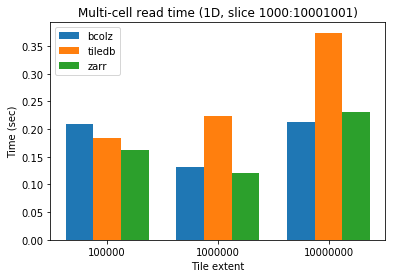

In [9]:
subarray_read_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
subarray = (1000, 1000 + tile_extents[-1] + 1)
for t_ext in tile_extents:
    remove_arrays()
    write_1d_tiledb_array(array_data, t_ext)
    write_1d_bcolz_array(array_data, t_ext)
    write_1d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_1d_subarray(subarray), repeat=5)))
    subarray_read_times['bcolz'].append(min(timeit(lambda: read_bcolz_1d_subarray(subarray), repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_1d_subarray(subarray), repeat=5)))

plot_bars(subarray_read_times, 'Multi-cell read time (1D, slice {}:{})'.format(*subarray),
          'Tile extent', 'Time (sec)')


interpret above results

# multi-dimensional arrays

increased dimensionality of the data requires different design decisions.

bcolz is not suitable for ND data, so we will omit it from here on out. this is because it can only chunk along one dimension, and thus will perform extremely poorly for nd slices.

zarr supports chunking along multiple dimensions, as does tiledb.

## array creation

we'll start by creating some synthetic 2D data and writing the arrays.

In [10]:
num_array_values = 10000, 10000
array_data = np.random.rand(*num_array_values)
print('2D array data is {:.2f} MB uncompressed.'.format(array_data.nbytes / (1024 * 1024.0)))


def write_2d_tiledb_array(array_data, tile_extents):
    shape = array_data.shape
    ctx = tiledb.Ctx()
    dom = tiledb.Domain(ctx,
                        tiledb.Dim(ctx, domain=(0, shape[0] - 1), tile=tile_extents[0], dtype=np.uint32),
                        tiledb.Dim(ctx, domain=(0, shape[1] - 1), tile=tile_extents[1], dtype=np.uint32))
    schema = tiledb.ArraySchema(ctx, domain=dom, sparse=False,
                                attrs=[tiledb.Attr(ctx, name='a', dtype=np.float64, compressor=tiledb_compressor)])
    tiledb.DenseArray.create(tiledb_array_path, schema)
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='w') as A:
        A[:] = array_data
    sync_fs()


def write_2d_zarr_array(array_data, tile_extents):
    A = zarr.open(zarr_array_path, mode='w', compressor=zarr_compressor, shape=array_data.shape, chunks=tile_extents,
                  dtype=np.float64)
    A[:] = array_data
    sync_fs()


2D array data is 762.94 MB uncompressed.


next we can time the array creation time for 2D arrays.

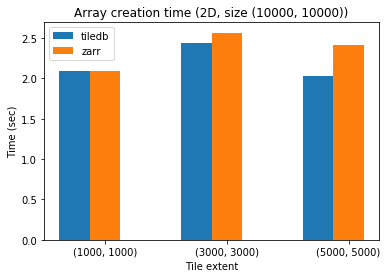

In [11]:
array_creation_times = {'tiledb': [], 'zarr': []}
tile_extents = [(1000, 1000), (3000, 3000), (5000, 5000)]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_2d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_2d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

plot_bars(array_creation_times, 'Array creation time (2D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')

interpret above results

## single-cell read

to begin with we'll define similar helper functions which read a 2D subarray:

In [12]:
def read_tiledb_2d_subarray(subarray):
    ctx = tiledb.Ctx()
    drop_fs_cache()
    with tiledb.DenseArray(ctx, tiledb_array_path, mode='r') as A:
        data = A[subarray[0] : subarray[1], subarray[2] : subarray[3]]


def read_zarr_2d_subarray(subarray):
    drop_fs_cache()
    A = zarr.open(zarr_array_path, mode='r')
    data = A[subarray[0] : subarray[1], subarray[2] : subarray[3]]


next we'll time and plot the results.

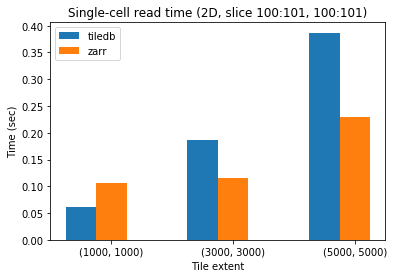

In [13]:
single_cell_read_times = {'tiledb': [], 'zarr': []}
subarray = (100, 101, 100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=10)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=10)))

plot_bars(single_cell_read_times, 'Single-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

## Multi-cell reads

next we'll repeat the above experiment but with a larger subarray slice. for this experiment we will choose a slice that crosses both tiles of the largest tile size.

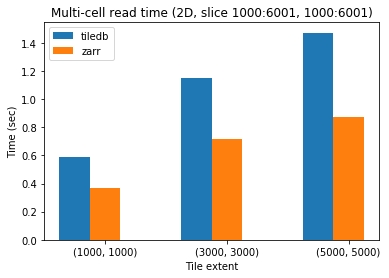

In [14]:
subarray_read_times = {'tiledb': [], 'zarr': []}
subarray = (1000, 6001, 1000, 6001)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=5)))

plot_bars(subarray_read_times, 'Multi-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

interpret above results

# Cloud storage

so far all of the above comparisons have happened on local disk.

we'll now repeat the 2D comparison with zarr, but the array will be persisted on an AWS S3 bucket.

first some configuration, and we'll redefine `remove_arrays()` to be able to interact with S3.

In [15]:
s3_bucket_name = 'tiledb-bench'

def remove_arrays():
    ctx = tiledb.Ctx()
    vfs = tiledb.VFS(ctx)
    tiledb_uri = 's3://{}/{}'.format(s3_bucket_name, tiledb_array_name)
    zarr_uri = 's3://{}/{}'.format(s3_bucket_name, zarr_array_name)
    if vfs.is_dir(tiledb_uri):
        vfs.remove_dir(tiledb_uri)
    if vfs.is_dir(zarr_uri):
        vfs.remove_dir(zarr_uri)


next we'll swap out the array "name" variables so that both TileDB and Zarr direct their operations to arrays on S3.

In [16]:
import s3fs

zarr_s3 = s3fs.S3FileSystem(key=os.environ['AWS_ACCESS_KEY_ID'],
                            secret=os.environ['AWS_SECRET_ACCESS_KEY'])
zarr_s3_store = s3fs.S3Map(root=s3_bucket_name + '/' + zarr_array_name,
                           s3=zarr_s3, check=False)
zarr_array_path = zarr_s3_store
tiledb_array_path = 's3://{}/{}'.format(s3_bucket_name, tiledb_array_name)

## Array creation

first up we'll repeat the array creation tests, now on S3.

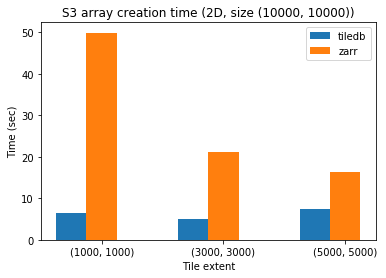

In [17]:
array_creation_times = {'tiledb': [], 'zarr': []}
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_2d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_2d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    
plot_bars(array_creation_times, 'S3 array creation time (2D, size {})'.format(num_array_values),
          'Tile extent', 'Time (sec)')


interpret above results

## single-cell read

next we'll repeat the single-cell reads on S3.

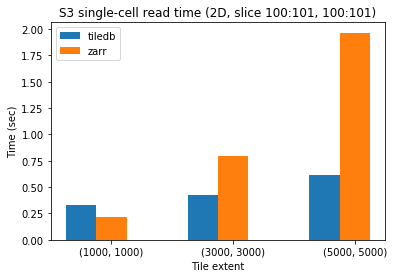

In [18]:
single_cell_read_times = {'tiledb': [], 'zarr': []}
subarray = (100, 101, 100, 101)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    single_cell_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=10)))
    single_cell_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=10)))

plot_bars(single_cell_read_times, 'S3 single-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')

interpret above results

## multi-cell read

finally we'll repeat the multi-cell reads on S3.

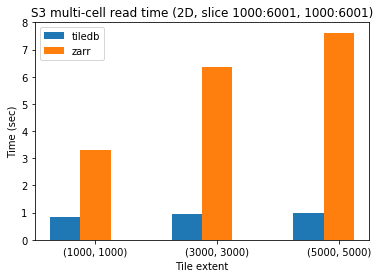

In [19]:
subarray_read_times = {'tiledb': [], 'zarr': []}
subarray = (1000, 6001, 1000, 6001)
for t_ext in tile_extents:
    remove_arrays()
    write_2d_tiledb_array(array_data, t_ext)
    write_2d_zarr_array(array_data, t_ext)
    subarray_read_times['tiledb'].append(min(timeit(lambda: read_tiledb_2d_subarray(subarray), repeat=5)))
    subarray_read_times['zarr'].append(min(timeit(lambda: read_zarr_2d_subarray(subarray), repeat=5)))

plot_bars(subarray_read_times, 'S3 multi-cell read time (2D, slice {}:{}, {}:{})'.format(*subarray), 
          'Tile extent', 'Time (sec)')


interpret above resutls

# conclusion